In [19]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision import transforms

from dataset import SatelliteImageDataset
from utils import save_model

from adunet.adunet import ADUNet

from utils import (
    compute_accuracy,
    compute_per_class_f1_score,
    class_index_to_image,
    one_hot_to_image,
    plot_prediction
)



In [ ]:
# Training Config
BATCH_SIZE = 4
EPOCHS = 100 
LEARNING_RATE = 1e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cpu


In [27]:
from dataset import SatelliteImageDataset
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

dataset = SatelliteImageDataset(
    image_dir='data/images',
    mask_dir='data/masks',
    transform=transform
)


In [28]:
# Initialize ADUNet model
model = ADUNet(in_channels=3, out_channels=6).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [29]:
from torch.utils.data import DataLoader, random_split
from dataset import SatelliteImageDataset

# Dataset banayein
dataset = SatelliteImageDataset(
    image_dir='data/images',
    mask_dir='data/masks'
)

# Train/test split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader banayein
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)



Epoch 1/1


C:\Users\ayush\AppData\Local\Temp\ipykernel_58288\3538632289.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  avg_f1 = torch.tensor(running_f1).mean().item()


Accuracy: 0.7209 | Loss: 1.4475 | IoU: 0.7209 | F1: 0.1667


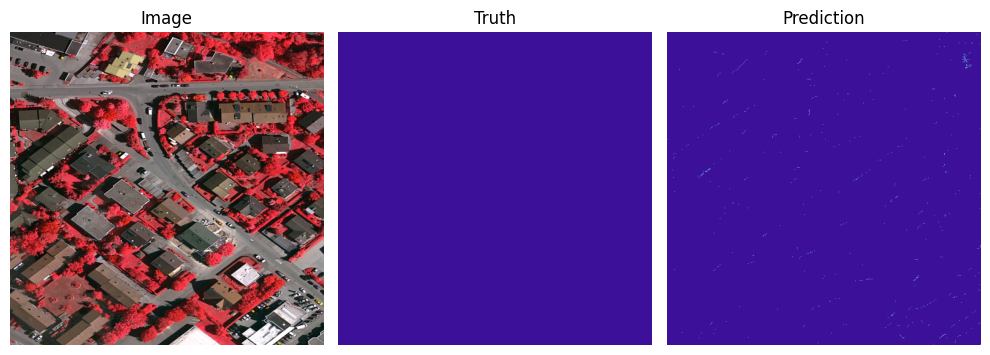

In [24]:
loss_list = []
acc_list = []
iou_list = []
f1_list = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    model.train()

    running_loss = 0.0
    running_acc = 0.0
    running_iou = []
    running_f1 = []

    for images, masks in train_loader:
        images = images.to(DEVICE)
        masks = masks.long().to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += compute_accuracy(masks, outputs, DEVICE)

        # IOU and F1 per batch
        f1_scores = compute_per_class_f1_score(masks, outputs, num_classes=6, device=DEVICE)
        running_f1.append(f1_scores)

        preds = torch.argmax(outputs, dim=1)
        iou = (preds == masks).float().mean().item()  # crude batch-level IoU
        running_iou.append(iou)

    avg_loss = running_loss / len(train_loader)
    avg_acc = running_acc / len(train_loader)
    avg_f1 = torch.tensor(running_f1).mean().item()
    avg_iou = sum(running_iou) / len(running_iou)

    loss_list.append(avg_loss)
    acc_list.append(avg_acc)
    f1_list.append(avg_f1)
    iou_list.append(avg_iou)

    print(f"Accuracy: {avg_acc:.4f} | Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f} | F1: {avg_f1:.4f}")

    if epoch % 10 == 0:
        y_imgs = class_index_to_image(masks, dataset.color_map, DEVICE)
        pred_imgs = one_hot_to_image(outputs, dataset.color_map, DEVICE)
        plot_prediction(images, y_imgs, pred_imgs, dataset.color_map, dataset.mask_labels)


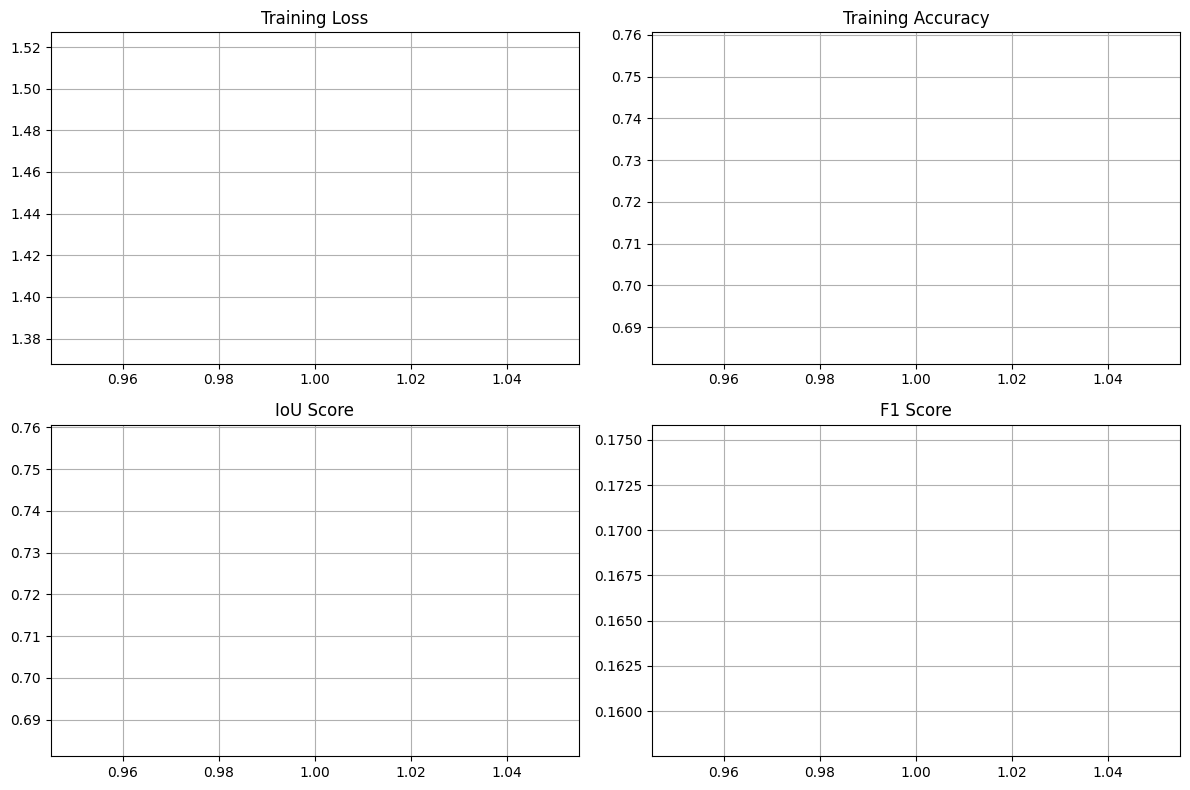

In [33]:
epochs_range = range(1, len(loss_list) + 1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, loss_list, label='Loss', color='red')
plt.title("Training Loss"); plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs_range, acc_list, label='Accuracy', color='blue')
plt.title("Training Accuracy"); plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs_range, iou_list, label='IoU', color='green')
plt.title("IoU Score"); plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs_range, f1_list, label='F1 Score', color='purple')
plt.title("F1 Score"); plt.grid(True)

plt.tight_layout()
plt.show()


In [25]:
# Save trained model
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': EPOCHS
}

torch.save(checkpoint, 'adunet/adunet_100ep_checkpoint.pth')
print("Model saved successfully!")


Model saved successfully!
